In [1]:
#TODO: Write function to run algorithm on all coins and see if any call would have lost money (negative price action)
#TODO: Fine tune filters
#TODO: Write function that takes in list of coins and buys those if pump occurs
#TODO: Output all pumps

In [2]:
from contextlib import closing
import json
from numpy import array, dtype, mean as np_mean, exp, linspace, convolve, log
from datetime import datetime
from decimal import Decimal

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick

from scipy import stats

from MySQLdb import connect, OperationalError, ProgrammingError

from crocket.utilities.passcode import AESCipher
from crocket.sql.sql import Database

CREDENTIALS_FILE_PATH = '/Users/brian/crypto/.credentials.json'
ENCRYPTED_FAKE_KEY = 'kS9fYyw94g7sWI/7L0pVi91ZFeiitH4Rk54vacZWwLvi6Nxoe64zUVMWjELor0th'

HOSTNAME = '173.255.241.200'
DATABASE_NAME = 'BITTREX'

In [3]:
# Decrypt the fake key to get the real key
fake_cipher = AESCipher('passcode')

real_key = fake_cipher.decrypt(ENCRYPTED_FAKE_KEY.encode())

cipher = AESCipher(real_key)

# Load credentials
with open(CREDENTIALS_FILE_PATH, 'r') as f:
    credentials = json.load(f)

USERNAME = cipher.decrypt(credentials.get('username').encode())
PASSCODE = cipher.decrypt(credentials.get('passcode').encode())

In [4]:
def calculate_average(input_vector, bin_size):
    
    truncated_vector = input_vector[len(input_vector)-int(len(input_vector)/bin_size)*bin_size:]
    
    return np_mean(np_array(truncated_vector).reshape(-1, bin_size), axis=1)

def calculate_rate_of_change(values, lag):
    
    if (lag > len(values)):
        raise ValueError('Period is larger than number of data points available.')
    
    lag += 1
    
    return ((values[-1] - values[-lag]) / values[-lag]) * 100

def calculate_change_over_time(values, alpha, periods):
    
    if alpha < 0 or alpha > 1:
        raise ValueError('Alpha must be between [0, 1]')
        
    value_changes = [calculate_rate_of_change(values, x)*alpha*(1-alpha)**i for i, x in enumerate(periods[:-1])] + \
    [calculate_rate_of_change(values, periods[-1])*(1-alpha)**(len(periods)-1)]
    
    return sum(value_changes), all([x for x in value_changes if x > 0])

def calculate_total_change(values, lag):
    
    if (lag > len(values)):
        raise ValueError('Period is larger than number of data points available.')
    
    lag += 1
    
    return (values[-1] - values[-lag])

def calculate_total_change_over_time(change, alpha, periods):
    
    if alpha < 0 or alpha > 1:
        raise ValueError('Alpha must be between [0, 1]')
        
    total_changes = [calculate_total_change(change, x)*alpha*(1-alpha)**i for i, x in enumerate(periods[:-1])] + \
    [calculate_total_change(change, periods[-1])*(1-alpha)**(len(periods)-1)]
    
    return sum(total_changes)

def exp_moving_average_decimal(values, window):
    
    weights = array(exp(linspace(-1., 0., window)), dtype=dtype(Decimal))
    weights = [round(Decimal(x / weights.sum()), 8) for x in weights]
    a = convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a

def exp_moving_average(values, window):
    
    weights = exp(linspace(-1., 0., window))
    weights /= weights.sum()
    a = convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a

def convert_datetime_to_minutes(time):
    
    reference = datetime(1970, 1, 1)
    start = (time[0]-reference).total_seconds()
    time_minutes = [((time[x]-reference).total_seconds()-start)/60 for x in range(len(time))]
    
    return time_minutes

In [5]:
# Create database object

db = Database(hostname=HOSTNAME,
              username=USERNAME,
              password=PASSCODE,
              database_name=DATABASE_NAME)

In [ ]:
# TODO: Debug ZEC

In [6]:
# TODO: Fix slow query time
data = db.select_query('BTC-ZEC', '*') # `BTC-GCR` # TODO: Fix false positives in `BTC-BRX` (consecutive time points)
time, price, basevolume, volume, buyorder, sellorder = map(list, zip(*data))

In [7]:
def detect_pump(time, price, basevolume, buyorder, sellorder):
    
    pema = exp_moving_average_decimal(price, 2)
    procl, procln = zip(*[calculate_change_over_time(pema, Decimal(0.8), range(5, 8))])
    procs, procsn = zip(*[calculate_change_over_time(pema, Decimal(0.8), range(1, 4)) 
                          for x in range(20, len(pema))])

    vema = exp_moving_average(basevolume, 2)
    vrocl, vrocln = zip(*[calculate_change_over_time(vema, 0.8, range(5, 8))])
    vrocs, vrocsn = zip(*[calculate_change_over_time(vema, 0.8, range(1, 4))])
    
    sema = exp_moving_average(sellorder, 2)
    srocl, srocln = zip(*[calculate_change_over_time(sema, 0.8, [1, 2, 3, 5, 8])])
    srocs, srocsn = zip(*[calculate_change_over_time(sema, 0.8, range(1, 4))])
    
    if (procl[-1] > 0.1 and procl[-1] < 3 and procs[-1] > 0.1 and procsn[-1] and
        vrocl[-1] > 0.3 and vrocl[-1] < 10 and vrocs[-1] > 0.3 and
        srocl[-1] < -0.2 and srocs[-1] < -0.2 and srocsn[-1]):
        
        return time[-1]
        
    
    # TODO: add buy order and sell order percent change and slope change (ONLY NEED ONE)

In [8]:
window_size = 25
calls = [detect_pump(time[x-window_size:x], 
                     price[x-window_size:x], 
                     basevolume[x-window_size:x], 
                     buyorder[x-window_size:x], 
                     sellorder[x-window_size:x]) for x in range(25, len(time))]

calls = [x for x in calls if x]
indices = [i for (i, x) in enumerate(time) if x in calls]
print(len(indices))

54


In [11]:
indices

[134,
 155,
 164,
 300,
 309,
 1532,
 1990,
 2137,
 2662,
 2663,
 2664,
 2665,
 3013,
 3070,
 3071,
 3072,
 3073,
 3112,
 3117,
 3139,
 3144,
 3145,
 3151,
 3166,
 3168,
 3219,
 3220,
 3228,
 3229,
 3233,
 3234,
 3435,
 3589,
 3723,
 3724,
 3735,
 3736,
 4493,
 4494,
 4495,
 4506,
 4514,
 4515,
 4539,
 4540,
 4618,
 4892,
 4893,
 7885,
 8113,
 8114,
 10194,
 10196,
 10197]

In [9]:
start = 0
stop = len(time)

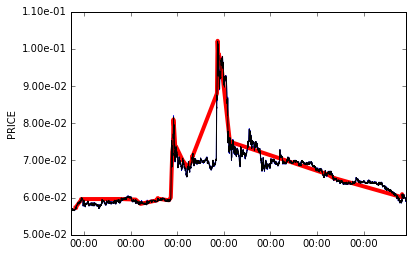

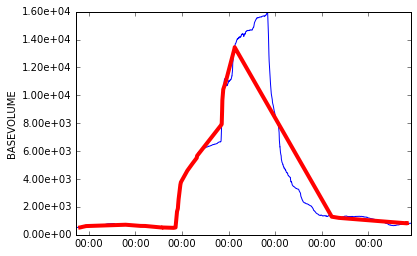

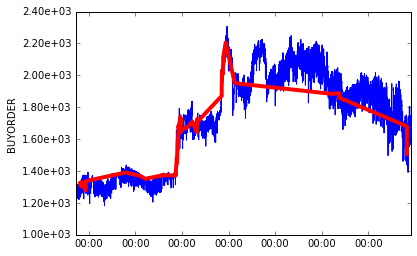

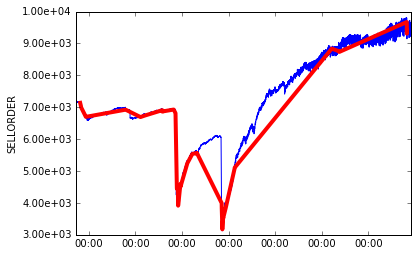

In [10]:
priceema = exp_moving_average_decimal(price, 2)

plt.plot(time[start:stop], price[start:stop])
plt.plot([time[x] for x in indices if x > start and x < stop], 
         [price[x] for x in indices if x > start and x < stop], 'r', linewidth=4)
plt.plot(time[start:stop], priceema[start:stop], 'k')
ax = plt.gca()
plt.ylabel('PRICE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], basevolume[start:stop])
plt.plot([time[x] for x in indices if x > start and x < stop], 
         [basevolume[x] for x in indices if x > start and x < stop], 'r', linewidth=4)
ax = plt.gca()
plt.ylabel('BASEVOLUME')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], buyorder[start:stop])
plt.plot([time[x] for x in indices if x > start and x < stop], 
         [buyorder[x] for x in indices if x > start and x < stop], 'r', linewidth=4)
ax = plt.gca()
plt.ylabel('BUYORDER')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], sellorder[start:stop])
plt.plot([time[x] for x in indices if x > start and x < stop], 
         [sellorder[x] for x in indices if x > start and x < stop], 'r', linewidth=4)
ax = plt.gca()
plt.ylabel('SELLORDER')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

In [13]:
60*24*2

2880

In [ ]:
priceema = exp_moving_average_decimal(price, 2)
vema = exp_moving_average(basevolume, 2)
vrocl = [calculate_volume_change_over_time(vema[:x], 0, [1, 2, 3, 5, 8, 13]) for x in range(100, len(vema))]
vrocs0 = [calculate_total_change_over_time(vema[:x], 0, range(1, 5)) for x in range(100, len(vema))]
vrocs2 = [calculate_total_change_over_time(vema[:x], 0.5, range(1, 5)) for x in range(100, len(vema))]
vrocs1 = [calculate_total_change_over_time(vema[:x], 0.8, range(1, 5)) for x in range(100, len(vema))]

In [ ]:
start = 2400
stop = 2500

In [ ]:
plt.plot(time[start:stop], price[start:stop])
plt.plot(time[start:stop], priceema[start:stop], 'r')
ax = plt.gca()
plt.ylabel('PRICE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], basevolume[start:stop])
plt.plot(time[start:stop], vema[start:stop], 'r')
ax = plt.gca()
plt.ylabel('VOLUME')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], vrocl[start-100:stop-100])
ax = plt.gca()
plt.ylabel('VOLUME RATE OF CHANGE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], vrocs0[start-100:stop-100], 'b')
plt.plot(time[start:stop], vrocs1[start-100:stop-100], 'r')
plt.plot(time[start:stop], vrocs2[start-100:stop-100], 'k')
ax = plt.gca()
plt.ylabel('VOLUME RATE OF CHANGE SLOPE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

In [ ]:
def detect_sell(values, time):

    sema = exp_moving_average(values, 2)
    srocl, srocln = zip(*[calculate_change_over_time(sema, 0.8, [1, 2, 3, 5, 8])])
    srocs, srocsn = zip(*[calculate_change_over_time(sema, 0.8, range(1, 4))])
    
    if (srocl[-1] < -0.2 and srocs[-1] < -0.2):
        
        print(time[-1], srocl[-1])
        return time[-1]

window_size = 25
calls = [detect_sell(sellorder[x-window_size:x],
                     time[x-window_size:x]) for x in range(5100, 5200)]


indices = [i for (i, x) in enumerate(time) if x in calls]
print(len(indices))

In [ ]:
[time[x] for x in indices]

In [ ]:
[srocl[x-99] for x in indices]

In [ ]:
sema = exp_moving_average(sellorder, 2)
srocl, na1 = zip(*[calculate_change_over_time(sema[:x], 0.8, [1, 2, 3, 5, 8]) 
                              for x in range(100, len(sema))])
srocs, na2 = zip(*[calculate_change_over_time(sema[:x], 0.8, range(1, 4)) 
                      for x in range(100, len(sema))])

In [ ]:
start = 5120
stop = 5150

In [ ]:
plt.plot(time[start:stop], sellorder[start:stop])
plt.plot([time[x] for x in indices if x > start and x < stop], 
         [sellorder[x] for x in indices if x > start and x < stop], 'r', linewidth=3)
ax = plt.gca()
plt.ylabel('SELLORDER')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], srocl[start-99:stop-99])
plt.plot([time[x] for x in indices if x > start and x < stop], 
         [srocl[x-99] for x in indices if x > start and x < stop], 'r', linewidth=3)
ax = plt.gca()
plt.ylabel('SELLORDER LONG')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], srocs[start-99:stop-99])
plt.plot([time[x] for x in indices if x > start and x < stop], 
         [srocs[x-99] for x in indices if x > start and x < stop], 'r', linewidth=3)
ax = plt.gca()
plt.ylabel('SELLORDER SHORT')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

In [ ]:
pema = exp_moving_average_decimal(price, 3)
procl = [calculate_volume_change_over_time(pema[:x], 0, [1, 2, 3, 5, 8]) for x in range(20, len(pema))]
procs = [calculate_volume_change_over_time(pema[:x], 0, range(0, 3)) for x in range(20, len(pema))]

In [ ]:
start = 2
stop = 2500

In [ ]:
plt.plot(time[start:stop], price[start:stop])
plt.plot(time[start:stop], pema[start:stop], 'r')
ax = plt.gca()
plt.ylabel('PRICE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], procl[start-100:stop-100])
ax = plt.gca()
plt.ylabel('PRICE LONG')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], procs[start-100:stop-100])
ax = plt.gca()
plt.ylabel('PRICE SHORT')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

In [ ]:
from pandas import DataFrame, set_option
from pandas.stats.moments import ewma
from numpy import vstack, mean

In [ ]:
# Set precision to 8
set_option('precision', 8)

In [ ]:
df = DataFrame(price)

In [ ]:
smooth2 = df.rolling(window=2).mean()
smooth3 = df.rolling(window=3).mean()
smooth10 = df.rolling(window=100).mean()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick

plt.plot(time[start:stop], smooth2[start:stop])
ax = plt.gca()
plt.ylabel('PRICE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], smooth3[start:stop])
ax = plt.gca()
plt.ylabel('PRICE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], smooth10[start:stop])
ax = plt.gca()
plt.ylabel('PRICE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

In [ ]:
from numpy import array, dtype, exp, linspace, convolve

In [ ]:
a = array(exp(linspace(-1., 0., 10)), dtype=dtype(Decimal))

In [ ]:
from decimal import Decimal

In [ ]:
Decimal(exp(linspace(-1., 0., 20)))

In [ ]:
weights = array(exp(linspace(-1., 0., 20)), dtype=dtype(Decimal))
weights = [round(Decimal(x / weights.sum()), 8) for x in weights]
a = convolve(price, weights, mode='full')[:len(price)]

In [ ]:
tmp = exp_moving_average(price, 20)
tmp1 = exp_moving_average(price, 40)
tmp2 = exp_moving_average(price, 10)

In [ ]:
start = 1350
stop = 1600

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick

plt.plot(time[start:stop], price[start:stop])
plt.plot(time[start:stop], tmp[start:stop], 'r')
plt.plot(time[start:stop], tmp1[start:stop], 'g')
plt.plot(time[start:stop], tmp2[start:stop], 'k')
ax = plt.gca()
plt.ylabel('PRICE')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

plt.plot(time[start:stop], volume[start:stop], 'k')
ax = plt.gca()
plt.ylabel('VOLUME')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()